In [126]:
import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from cmath import isnan
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('Pendulum-v1', render_mode='rgb_array')

# matplotlibの設定
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
  from IPython import display

plt.ion()

# gpuが使用される場合の設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [127]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
    
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity # サイクルバッファ
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [128]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, lr=0.003): # state_dim: (B, C, H, W)
        super(PolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # 線形レイヤへの入力次元の数は、conv2dレイヤーの出力のサイズに依存（元を辿れば入力画像のサイズに依存）します。
        # そこで、conv2dレイヤーの出力サイズを計算しています。
        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        h = state_dim[2]
        w = state_dim[3]
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        linear_input_size = convw * convh * 32
        self.linear1 = nn.Linear(linear_input_size, 64)
        # self.linear2 = nn.Linear(64, 64)
        self.pi_mean = nn.Linear(64, action_dim)
        self.pi_stddev = nn.Linear(64, action_dim)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.linear1(x.view(x.size(0), -1))) # 画像を行ベクトルに変換
        # x = F.relu(self.linear2(x))
        mean = self.pi_mean(x)
        log_stddev = self.pi_stddev(x)

        stddev = torch.exp(log_stddev)

        return mean, stddev

In [129]:
class DualQNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, lr=0.003): # state_dim: (B, C, H, W)
        super(DualQNetwork, self).__init__()

        def conv2d_size_out(size, kernel_size=5, stride=2):
            return (size - (kernel_size - 1) - 1) // stride + 1
        h = state_dim[2]
        w = state_dim[3]
        convh = conv2d_size_out(conv2d_size_out(conv2d_size_out(h)))
        convw = conv2d_size_out(conv2d_size_out(conv2d_size_out(w)))
        linear_input_size = convw * convh * 32

        # QNetwork 1
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.linear1 = nn.Linear(linear_input_size + action_dim, 64)
        # self.linear2 = nn.Linear(64, 64)
        self.q1 = nn.Linear(64, 1)

        # QNetwork 2
        self.conv4 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn4 = nn.BatchNorm2d(16)
        self.conv5 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn5 = nn.BatchNorm2d(32)
        self.conv6 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn6 = nn.BatchNorm2d(32)
        self.linear3= nn.Linear(linear_input_size + action_dim, 64)
        # self.linear4 = nn.Linear(64, 64)
        self.q2 = nn.Linear(64, 1)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        
    def forward(self, s, a):
        # # QNetwork 1
        s1 = F.relu(self.bn1(self.conv1(s)))
        s1 = F.relu(self.bn2(self.conv2(s1)))
        s1 = F.relu(self.bn3(self.conv3(s1)))

        x1 = torch.cat([s1.view(s1.size(0), -1), a], 1)  # combination s and a
        x1 = F.relu(self.linear1(x1))
        # x1 = F.relu(self.linear2(x1))
        q_value1 = self.q1(x1)

        # QNetwork 2
        s2 = F.relu(self.bn4(self.conv4(s)))
        s2 = F.relu(self.bn5(self.conv5(s2)))
        s2 = F.relu(self.bn6(self.conv6(s2)))

        x2 = torch.cat([s2.view(s2.size(0), -1), a], 1)  # combination s and a
        x2 = F.relu(self.linear3(x2))
        # x2 = F.relu(self.linear4(x2))
        q_value2 = self.q2(x2)

        return q_value1, q_value2


In [130]:
class SAC():
    def __init__(self, state_dim, action_space, buffer_size, gamma, soft_target_tau, hard_target_interval, 
                 target_entropy, policy_lr, q_lr, alpha_lr):
        super(SAC, self).__init__()

        self.state_dim = state_dim
        self.action_dim = action_space.shape[0]

        # Envアクション用にスケールする
        self.action_center = torch.FloatTensor((action_space.high + action_space.low) / 2).to(device)
        self.action_scale = torch.FloatTensor(action_space.high - self.action_center.cpu().detach().numpy()).to(device)

        # Neural Networks
        self.policy_net = PolicyNetwork(self.state_dim, self.action_dim, policy_lr).to(device)
        
        self.q_net = DualQNetwork(self.state_dim, self.action_dim, q_lr).to(device)
        self.target_q_net = DualQNetwork(self.state_dim, self.action_dim, q_lr).to(device)

        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(param.data)

        self.replay_memory = ReplayMemory(buffer_size)

        
        self.target_entropy = -self.action_dim
        self.log_alpha = torch.zeros(1, requires_grad=True)
        self.alpha_optimizer = optim.Adam([self.log_alpha], lr=alpha_lr)

        # Hyper Parameters
        self.gamma = gamma
        self.soft_target_tau = soft_target_tau
        self.target_entropy = target_entropy

    def sample_action(self, state):
        mean, stddev = self.policy_net(state)

        # Reparameterization
        normal_random = torch.normal(0, 1, size=mean.shape).to(device)
        action_org = mean + stddev * normal_random

        # Squashed Gaussian Policy
        action = torch.tanh(action_org)

        return action.to(device), mean.to(device), stddev.to(device), action_org.to(device)

    def sample_action_for_env(self, state):
        action, _, _, _ = self.sample_action(state)
        env_action = action * self.action_scale + self.action_center

        return env_action.cpu().detach().numpy()[0], action.cpu().detach().numpy()[0]

    # 正規分布でのactionの対数確率密度関数logμ(a|s)
    def compute_logpi(self, mean, stddev, action):
        a1 = -0.5 * np.log(2*np.pi)
        a2 = -torch.log(stddev)
        a3 = -0.5 * (((action - mean) / stddev) ** 2)
        return (a1 + a2 + a3).to(device)

    # tanhで変換されたactionのlogπ(a|s)をaction_orgを使って計算
    def compute_logpi_sgp(self, mean, stddev, action_org):
        logmu = self.compute_logpi(mean, stddev, action_org)
        tmp = 1 - torch.tanh(action_org) ** 2
        tmp = torch.clip(tmp, 1e-10, 1.0)  # log(0)回避
        logpi = logmu - torch.sum(torch.log(tmp), 1, keepdim=True)
        return logpi.to(device)


    def update(self, batch_size, q_net_sync=False):
        # 経験をバッチでサンプリング
        transitions = self.replay_memory.sample(batch_size)
        batch = Transition(*zip(*transitions))
        
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        n_state_batch = torch.cat(batch.next_state)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        alpha = torch.exp(self.log_alpha)
        
        # Q(s,a)の推定値を計算し, Q値の損失関数を計算
        with torch.no_grad():
            n_action, n_mean, n_stddev, n_action_org = self.sample_action(n_state_batch)
            
            n_logpi = self.compute_logpi_sgp(n_mean, n_stddev, n_action_org)
            n_q1, n_q2 = self.target_q_net(n_state_batch, n_action)
          
            q_est = reward_batch + (1 - done_batch) * self.gamma * torch.minimum(n_q1, n_q2) - (alpha * n_logpi)
        q1, q2 = self.q_net(state_batch, action_batch.detach())
        q1_loss = F.mse_loss(q1, q_est.float())
        q2_loss = F.mse_loss(q2, q_est.float())
        q_loss = q1_loss + q2_loss
        
        # q_lossからQNetworkを学習
        self.q_net.optimizer.zero_grad()
        q_loss.backward()
        self.q_net.optimizer.step()

        # 方策の損失関数を計算
        action, mean, stddev, action_org = self.sample_action(state_batch) # 現在の方策π(θ)で選ばれるactionについて評価     
        logpi = self.compute_logpi_sgp(mean, stddev, action_org)
        q1, q2 = self.q_net(state_batch, action)
        q_min = torch.minimum(q1, q2)
        policy_loss = -(q_min - alpha.detach() * logpi).mean()

        # policy_lossからPolicyNetworkを学習
        self.policy_net.optimizer.zero_grad()
        policy_loss.backward()
        self.policy_net.optimizer.step()

        # αの自動調整
        alpha_loss = (-alpha * (logpi + self.target_entropy).detach()).mean()
        self.alpha_optimizer.zero_grad()
        alpha_loss.backward()
        self.alpha_optimizer.step()

        # ソフトターゲットで更新
        for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.soft_target_tau) + param.data * self.soft_target_tau)

        # q_net_syncフラグが有効ならq_netを同期させる
        if q_net_sync:
            for target_param, param in zip(self.target_q_net.parameters(), self.q_net.parameters()):
                target_param.data.copy_(param.data)

        return policy_loss.cpu().detach().numpy(), q_loss.cpu().detach().numpy()

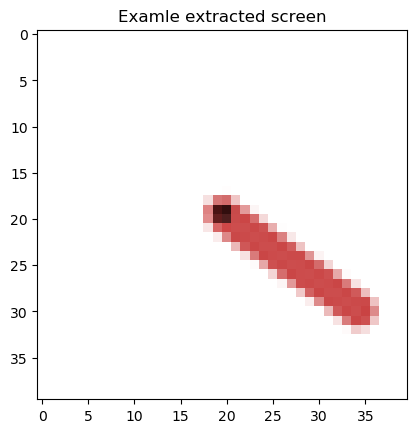

In [131]:
resize = T.Compose([T.ToPILImage(), T.Resize(40, T.InterpolationMode.BICUBIC), T.ToTensor()])


def get_screen():
    # PyTorch標準のCHWに変換
    screen = env.render().transpose(2, 0, 1)
    _, screen_height, screen_width = screen.shape

    # sliceでscreenをトリミング
    height_slice = slice(int(screen_height*0.25), int(screen_height * 0.75))
    screen = screen[:, height_slice]
    width_slice = slice(int(screen_width*0.25), int(screen_width * 0.75))
    screen = screen[:, :, width_slice]

    # float32に変換し0-1に正規化
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255
    # Tensorに変換
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)


# Example
env.reset()
plt.figure()
plt.imshow(get_screen().cpu().squeeze(0).permute(1, 2, 0).numpy(), interpolation='none')
plt.title('Examle extracted screen')
plt.show()


In [132]:
# ハイパーパラメータ
buffer_size = 1000  # Experienceのキュー容量
warmup_size = 500  # 学習するかどうかのExperienceの最低限の容量
train_interval = 10  # 学習する制御周期間隔
batch_size = 32  # バッチサイズ
gamma = 0.9  # 割引率
soft_target_tau = 0.02  # Soft TargetでTargetに近づく割合
hard_target_interval = 100  # Hard Targetで同期する間隔
lr = 0.003
# エントロピーαの目標値: -1xアクション数がいいらしい
target_entropy = -1 * env.action_space.shape[0]

state_dim = get_screen().shape
sac = SAC(state_dim, env.action_space, buffer_size, gamma, soft_target_tau, hard_target_interval,
            target_entropy, lr, lr, lr)

step_count = 0
train_count = 0

# 記録用
history_rewards = []
history_metrics = []
history_metrics_y = []


# 学習ループ
for episode in range(500):
    env.reset()
    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    done = False
    total_reward = 0
    step = 0

    metrics_list = []

    # １エピソード
    while not done:
        # アクションを決定
        env_action, action = sac.sample_action_for_env(state)
        if isnan(env_action[0]):
            print("action is NaN. 学習失敗.")
            break
        # print("state:", state, "action:", action)

        _, reward, terminated, truncated, _ = env.step(env_action)
        
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            n_state = current_screen - last_screen
        else:
            n_state = None
        step += 1
        total_reward += reward
        done = terminated or truncated

        sac.replay_memory.push(
            state.clone().detach().to(device),
            torch.tensor(action, dtype=torch.float32).reshape(1, -1).to(device),
            n_state.clone().detach().to(device),
            torch.tensor(reward, dtype=torch.float32).reshape(1, -1).to(device),
            torch.tensor(done, dtype=torch.float32).reshape(1, -1).to(device))

        state = n_state

        # train_interval毎に, warmup貯まっていたら学習する
        if len(sac.replay_memory) >= warmup_size and step_count % train_interval == 0:
            q_net_sync = False
            if train_count % hard_target_interval == 0:
                q_net_sync = True
            # モデルの更新
            metrics = sac.update(
                batch_size,
                q_net_sync)
            train_count += 1
            metrics_list.append(metrics)
        step_count += 1

    # 報酬
    history_rewards.append(total_reward)

    # メトリクス
    if len(metrics_list) > 0:
        history_metrics.append(np.mean(metrics_list, axis=0))  # 平均を保存
        history_metrics_y.append(episode)

    #--- print
    interval = 20
    if episode % interval == 0:
        print("{} (min,ave,max)reward {:.1f} {:.1f} {:.1f}, alpha={:.3f}".format(
            episode,
            min(history_rewards[-interval:]),
            np.mean(history_rewards[-interval:]),
            max(history_rewards[-interval:]),
            torch.exp(sac.log_alpha).cpu().detach().numpy()[0],
        ))

env.close()

0 (min,ave,max)reward -979.5 -979.5 -979.5, alpha=1.000


KeyboardInterrupt: 

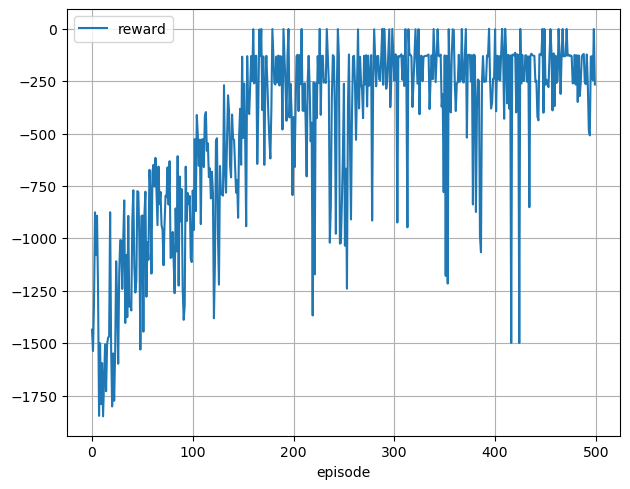

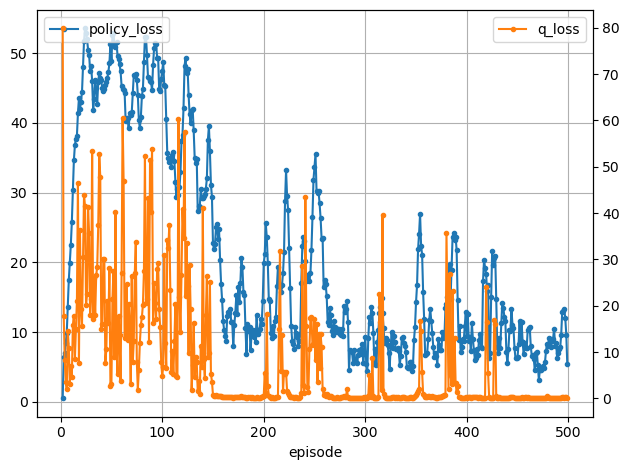

In [ ]:
# プロット
plt.plot(history_rewards, label="reward")
plt.tight_layout()
plt.xlabel('episode')
plt.grid()
plt.legend()
plt.show()

fig, ax1 = plt.subplots()

ax1.set_xlabel('episode')
ax1.grid()
ax1.plot(history_metrics_y, [m[0] for m in history_metrics], color="C0", marker='.', label="policy_loss")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(history_metrics_y, [m[1] for m in history_metrics], color="C1", marker='.', label="q_loss")
ax2.legend(loc='upper right')

fig.tight_layout()  # レイアウトの設定
# plt.savefig('cartpole2.png') # 画像の保存
plt.show()

In [ ]:
# テスト
from IPython import display
from pyvirtualdisplay import Display
from matplotlib import animation

env = gym.make("Pendulum-v1", render_mode='rgb_array')

d = Display()
d.start()
img = []

for episode in range(1):
    env.reset()

    last_screen = get_screen()
    current_screen = get_screen()
    state = current_screen - last_screen
    done = False
    total_reward = 0
    step = 0
    
    img.append(env.render())

    # １エピソード
    while not done:
        env_action, _ = sac.sample_action_for_env(torch.FloatTensor(state).reshape(1, -1))
        _, reward, terminated, truncated, _ = env.step(env_action)
        
        last_screen = current_screen
        current_screen = get_screen()
        if not done:
            state = current_screen - last_screen
        else:
            state = None
        total_reward += reward

        done = terminated or truncated

        step += 1

        # 動画化に毎step描画を追加
        display.clear_output(wait=True)
        img.append(env.render())

        if done:
            break

    print("{} step, reward: {}".format(step, total_reward))
env.close()


200 step, reward: -251.17103164545625


In [ ]:
# 動画を表示

dpi = 72
interval = 50  # ms

plt.figure(figsize=(img[0].shape[1]/dpi, img[0].shape[0]/dpi), dpi=dpi)
patch = plt.imshow(img[0])
plt.axis = ('off')
def animate(i): return patch.set_data(img[i])


ani = animation.FuncAnimation(plt.gcf(), animate, frames=len(img), interval=interval)
display.display(display.HTML(ani.to_jshtml()))
plt.close()